# Project "Training a cat to catch a Mouse using Q-learning and Qiskit"

Participants:

## 1. Intoduction 
### 1.1 Idea
The idea of this project is to train a novice(single agent) to catch a mouse in a grid environment 3*3. 

We placed the cat in the lower right corner and the mouse in the upper left corner. Our task is to find the best way for the cat to catch a motionless (and unsuspecting danger) mouse. We want to test whether it is possible to solve such a problem using quantum computing.

<table>
<tr>
    <th>MOUSE</th>
    <td>EMPTY</td>
    <td>EMPTY</td> 
</tr>

<tr>
    <td>EMPTY</td> 
    <td>EMPTY</td> 
    <td>EMPTY</td>
</tr>

<tr>
    <td>EMPTY</td> 
    <td>EMPTY</td> 
    <th>CAT</th>   
</tr>

</table>


### 1.2 Q-Learning
Q-Learning is a reinforcement learning algorithm to learn the value of an action in a particular state.
When Q-learning is performed we create what’s called a **q-table** or matrix that follows the shape of *[state, action]* and we initialize our values to zero. We then update and store our q-values after an episode. This q-table becomes a reference table for our agent to select the best action based on the q-value.


An agent interacts with the environment in 1 of 2 ways. The first is to use the q-table as a reference and view all possible actions for a given state. The agent then selects the action based on the max value of those actions. This is known as **exploiting** since we use the information we have available to us to make a decision.


The second way to take action is to act randomly. This is called **exploring**. Instead of selecting actions based on the max future reward we select an action at random. Acting randomly is important because it allows the agent to explore and discover new states that otherwise may not be selected during the exploitation process. You can balance exploration/exploitation using epsilon (ε) and setting the value of how often you want to explore vs exploit. Here’s some rough code that will depend on how the state and action space are setup.

Q-table is updated in every episode of training via **Bellman Equation**:
$$
\begin{align}
\underbrace{\text{New}Q(s,a)}_{\scriptstyle\text{New Q-Value}}=Q(s,a)+\mkern-34mu\underset{\text{New Q-Value}}{\underset{\Bigl|}{\alpha}}\mkern-30mu \underbrace{R(s,a)}_{\scriptstyle\text{Reward}}+ \mkern-30mu\underset{\text{Discount rate}}{\underset{\Biggl |}{\gamma}}\mkern-75mu * \overbrace{\max Q'(s',a')}^{\scriptstyle\substack{\text{Maximum predicted reward, given} \\ \text{new state and all possible actions}}} * \mkern-45mu-Q(s,a)
\end{align}
$$

### 1.3 Variational Quantum Eigensolver (VQE)

VQE is an application of the variational method of quantum mechanics.
$$
\begin{align}
    \lambda_{min} \le \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle = \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2
\end{align}
$$
The above equation is known as the **variational method**.

When the Hamiltonian of a system is described by the Hermitian matrix $H$ the ground state energy of that system, $E_{gs}$, is the smallest eigenvalue associated with $H$. By arbitrarily selecting a wave function $|\psi \rangle$ (called an *ansatz*) as an initial guess approximating $|\psi_{min}\rangle$, calculating its expectation value, $\langle H \rangle_{\psi}$, and iteratively updating the wave function, arbitrarily tight bounds on the ground state energy of a Hamiltonian may be obtained. 

A systematic approach to varying the ansatz is required to implement the variational method on a quantum computer. VQE does so through the use of a parameterized circuit with a fixed form. Such a circuit is often called a *variational form*, and its action may be represented by the linear transformation $U(\theta)$. A variational form is applied to a starting state $|\psi\rangle$ (such as the vacuum state $|0\rangle$, or the Hartree Fock state) and generates an output state $U(\theta)|\psi\rangle\equiv |\psi(\theta)\rangle$. Iterative optimization over $|\psi(\theta)\rangle$ aims to yield an expectation value $\langle \psi(\theta)|H|\psi(\theta)\rangle \approx E_{gs} \equiv \lambda_{min}$. Ideally, $|\psi(\theta)\rangle$ will be close to $|\psi_{min}\rangle$ (where 'closeness' is characterized by either state fidelity, or Manhattan distance) although in practice, useful bounds on $E_{gs}$ can be obtained even if this is not the case.


## 2. Solution scheme via Q-learning & Quantum Calculations

The scheme of our solution a as follows: Each point of our medium of size 3*3 corresponds to a quantum circuit with configurable parameters. Each such scheme consists of several U3-gates, the type of which is shown below.

$$
\begin{align}
    U3(\theta, \phi, \lambda) = \begin{pmatrix}\cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\ e^{i\phi}\sin(\frac{\theta}{2}) & e^{i\lambda + i\phi}\cos(\frac{\theta}{2}) \end{pmatrix}
\end{align}
$$

One of the options for implementing such a quantum circuit looks like this:

![Image of the Circuit](https://files.fm/thumb_show.php?i=9mynvq8t9)


In [ ]:
from copy import deepcopy
import numpy as np
import random
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, transpile, assemble
from qiskit.providers import backend
from qiskit.aqua.components.optimizers import COBYLA
import matplotlib.pyplot as plt
import itertools

### 2.3 Basic Classes

**State** 

This class is needed for describing the position of the cat and operating with it. 

**GridWorld**

We use this for operating with out grid where the cat and the mouse are located.

**QNet**

Here we can perfrom all the quantum computation needed for updating the q-tables in each point.

**Cat**

This class describes the cat's actions and update q-circuits accordingly.

**PetSchool**

In this class we can train our model and show the results.

In [70]:
# TYPES:
CAT = "c"
MOUSE = "m"
EMPTY = "emp"

# ACTIONS:
UP = "00"
DOWN = "01"
LEFT = "10"
RIGHT = "11"
ACTIONS = [UP, DOWN, LEFT, RIGHT]

# random seed
random.seed(10)
np.random.seed(10)

In [71]:
# state of cat
class State:
    def __init__(self, catP):
        #self.row = catP[0]
        #self.column = catP[1]
        self.catP = catP

    def __eq__(self, other):
        return isinstance(other, State) and self.catP == other.catP

    def __hash__(self):
        return hash(str(self.catP))

    def __str__(self):
        return f"State(cat_pos={self.catP})"

In [72]:
# GridWorld
# e.g.
#  MOUSE | EMPTY | EMPTY
#  EMPTY | EMPTY | EMPTY
#  EMPTY | EMPTY | CAT
class GridWorld:
    def __init__(self, s, catP, mouseP):
        self.numRows = s[0]
        self.numColumns = s[1]
        self.catP = catP
        self.mouseP = mouseP
        # self.dogP = dogP
        assert(not self.compaireList(self.catP, self.mouseP))
    
    def getItem(self, p):
        if p[0]>=self.numRows or p[0]<0:
            return None
        if p[1]>=self.numColumns or p[1]<0:
            return None
        if self.compaireList(p, catP):
            return CAT
        elif self.compaireList(p, mouseP):
            return MOUSE
        # elif self.compaireList(p, DOG):
        #     return DOG
        else:
            return EMPTY

    def compaireList(self, l1,l2):
        for i, j in zip(l1, l2):
            if i!=j:
                return False
        return True

    def getNumRows(self):
        return self.numRows

    def getNumColumns(self):
        return self.numColumns

    def getMouse(self):
        return self.mouse
    
    def getCatP(self):
        return self.catP

    def setCatP(self, p):
        self.catP = p
        
    def setMouseP(self, p):
        self.mouseP = p
    
    def initCatState(self, rd = False):
        # init cat position
        if not rd:
            catP = [self.getNumRows() - 1, self.getNumColumns() - 1]
        else:
            catP = [random.randint(0, self.getNumRows()), random.randint(0, self.getNumColumns())]
            while self.getItem(catP) != EMPTY and self.getItem(catP) != CAT:
                catP = [random.randint(0, self.getNumRows()), random.randint(0, self.getNumColumns())]
        self.setCatP(catP)
        return State(catP)
    
    def show(self):
        output = ""
        for i in range(self.numRows):
            for j in range(self.numColumns):
                if self.compaireList([i,j], self.catP):
                    output += CAT + " "
                if self.compaireList([i,j], self.mouseP):
                    output += MOUSE + " "
                if not self.compaireList([i,j], self.catP) and not self.compaireList([i,j], self.mouseP):
                    output += EMPTY + " "
            output += "\n"
        print(output)

In [73]:
# QNet
class QNet:
    
    def __init__(self, qTable, gridWorld:GridWorld, alpha=0.1, gamma=1.0, eps=0.2, actions=[UP, DOWN, LEFT, RIGHT], numParams=6):
        self.gw = gridWorld
        self.qt = qTable
        self.eps = eps
        self.backend = Aer.get_backend("qasm_simulator")
        self.NUM_SHOTS = 1000 # number of measurements 
        self.optimizer = COBYLA(maxiter=500, tol=0.0001) # off the shelf
        self.gamma = gamma
        self.alpha = alpha
        self.ACTIONS = actions

        # self.rets = {(0,0):([0,..,0],0.0,0), ...}
        self.rets = dict() # resulting parameters after optimization for all points in the grid

        self.state = None
        
        for i in range(self.gw.getNumRows()):
            for j in range(self.gw.getNumColumns()):
                self.rets[i, j] = (np.random.rand(numParams), 0.0, 0) 
    
    def qcMaker(self, params):
        qr = QuantumRegister(2, name="q")
        cr = ClassicalRegister(2, name="c")
        qc = QuantumCircuit(qr, cr)
        qc.u3(params[0], params[1], params[2], qr[0])
        qc.u3(params[3], params[4], params[5], qr[1])
        # qc.cx(qr[0], qr[1]) # create entangelment
        qc.measure(qr, cr)
        return qc

    def newPosition(self, state, action):
        p = deepcopy(state.catP)
        if action == UP:
            p[0] = max(0, p[0] - 1)
        elif action == DOWN:
            p[0] = min(self.gw.getNumRows() - 1, p[0]+1)
        elif action == LEFT:
            p[1] = max(0, p[1] - 1)
        elif action == RIGHT:
            p[1] = min(self.gw.getNumColumns() - 1, p[1] + 1)
        else:
            raise ValueError(f"Unkown action {action}")
        return p
        
    def getReward(self, p):
        grid = self.gw.getItem(p)
        if grid == EMPTY:
            reward = -1
        elif grid == MOUSE:
            reward = 1000
        elif grid == CAT:
            reward = -1
        else:
            raise ValueError(f"Unknown grid item {grid}")
        return reward
    
    def selectAction(self, state, training):
        if random.uniform(0, 1) < self.eps:
            return random.choice(self.ACTIONS)
        else:
            if training:
                self.state = deepcopy(state)
                self.updateCircuit(state)
            return self.ACTIONS[np.argmax(self.qt[self.state.catP[0], self.state.catP[1]])]
        
    def lossFunction(self, params):
        action = ""
        qc = self.qcMaker(params=params)
        t_qc = transpile(qc, self.backend)
        job = assemble(t_qc, shots=self.NUM_SHOTS)
        rlt = self.backend.run(job).result()
        counts = rlt.get_counts(qc)
        # speedup training, cross the ravine
        if random.uniform(0, 1) < self.eps:
            action = random.choice(self.ACTIONS)
        else:
            action = max(counts, key = counts.get)
        
        nextPosition = self.newPosition(self.state, action) # handle the 
        reward = self.getReward(nextPosition)
        targetQvalue = reward + self.gamma *  np.max(self.qt[nextPosition[0],nextPosition[1]])
        predictedQvalue = self.calculateQvalue(action, nextPosition, reward, targetQvalue, self.state)
        
        # update q-table
        self.updateQtable(predictedQvalue, action)
        return targetQvalue - self.qt[self.state.catP[0],self.state.catP[1]][int(action,2)]
    
    def updateQtable(self, predictedQvalue, action):
        if self.qt[(self.state.catP[0],self.state.catP[1])][int(action,2)] < predictedQvalue:
            self.qt[self.state.catP[0],self.state.catP[1]][int(action,2)] = predictedQvalue

    def calculateQvalue(self, action, nextPosition, reward, targetQvalue, state:State):
        targetQvalue = reward + self.gamma *  np.max(self.qt[nextPosition[0],nextPosition[1]])
        return self.qt[state.catP[0], state.catP[1]][int(action,2)] + self.alpha * (targetQvalue - self.qt[state.catP[0],state.catP[1]][int(action,2)]) # update q-table

    def updateCircuit(self, state:State):
        self.rets[state.catP[0], state.catP[1]] = self.optimizer.optimize(num_vars=6, objective_function=self.lossFunction, initial_point=self.rets[state.catP[0], state.catP[1]][0])

    def setAlpha(self, alpha):
        self.alpha = alpha

    # @Daniel-Molpe
    def drawVectors(self, hasdiagonals):
        # Draw vectors representing the cat's desired direction for each place in the grid based on the Qtable
        x = np.linspace(0, self.gw.getNumColumns()-1, self.gw.getNumColumns())
        y = np.linspace(0, self.gw.getNumRows()-1, self.gw.getNumRows())
        vecx=np.zeros([len(x),len(y)])
        vecy=np.zeros([len(x),len(y)])
        for i in range(len(x)):
            for j in range(len(y)):
                vecx[i,j] = self.qt[(x[i], y[j])][3]-self.qt[(x[i], y[j])][2]
                vecy[i,j] = self.qt[(x[i], y[j])][0]-self.qt[(x[i], y[j])][1]
                norm = np.sqrt(vecx[i,j]**2 + vecy[i,j]**2)
                vecx[i,j]=-vecx[i,j]/norm
                vecy[i,j]=-vecy[i,j]/norm
        pts = itertools.product(x, y)
        plt.scatter(*zip(*pts), marker='o', s=30, color='red')
        X, Y = np.meshgrid(x, y)
        QP = plt.quiver(X, Y, vecx, vecy)
        plt.grid()
        plt.show()

In [74]:
# Agent: cat
class Cat:
    def __init__(self, qNet: QNet, training=True, eps = 0.2, actions = [UP, DOWN, LEFT, RIGHT]):
        self.eps = eps
        self.training = training
        self.qNet = qNet
        self.ACTIONS = actions
        self.state = None

    def newPosition(self, state, action):
            p = deepcopy(state.catP)
            if action == UP:
                p[0] = max(0, p[0] - 1)
            elif action == DOWN:
                p[0] = min(self.qNet.gw.getNumRows() - 1, p[0] + 1)
            elif action == LEFT:
                p[1] = max(0, p[1] - 1)
            elif action == RIGHT:
                p[1] = min(self.qNet.gw.getNumColumns() - 1, p[1] + 1)
            else:
                raise ValueError(f"Unkown action {self.ACTIONS[action]}")
            return p

    def getReward(self, p):
        grid = self.qNet.gw.getItem(p)
        if grid == MOUSE:
            reward = 1000
            end = True
        elif grid == EMPTY:
            reward = -1
            end = False
        elif grid == CAT:
            reward = -1
            end = False
        else:
            raise ValueError(f"Unknown grid item {grid}")
        return reward, end

    def act(self, state, action):
        p = self.newPosition(state, action)
        reward, end = self.getReward(p)
        return p, reward, end
    
    def updateQtable(self, action, p, reward, state):
        pqv = self.qNet.calculateQvalue(action, p, reward, state)
        self.qNet.updateQtable(pqv, action)

    def setTraining(self, training):
        self.Training = training

In [75]:
# The pet school
class PetSchool:
    def __init__(self, cat:Cat, numEpisodes, maxEpisodeSteps, training=True, minAlpha = 0.02, eps = 0.2):
        self.cat = cat
        self.training = training
        self.NUM_EPISODES = numEpisodes
        self.MAX_EPISODE_STEPS = maxEpisodeSteps
        self.alphas = np.linspace(1.0, minAlpha, self.NUM_EPISODES)
        self.eps = eps

    def train(self):
        a=[]
        b=[]
        counter = 0
        rd = True
        for e in range(self.NUM_EPISODES): #  episode: a rund for agent
            print("episode: ", e)
            if e > int(self.NUM_EPISODES/2):
                rd = False
            state = self.cat.qNet.gw.initCatState(rd=rd) # default is rd = False
            self.cat.qNet.setAlpha(self.alphas[e])
            total_reward  = 0
            step = 0
            end = False
            for _ in range(self.MAX_EPISODE_STEPS): # step: a time step for agent
                action = self.cat.qNet.selectAction(deepcopy(state), self.training)
                p, reward, end = self.cat.act(state, action)
                self.catMoveTo(p)
                # self.cat.updateQtable(action, p, reward, state) # speedup learning
                total_reward += reward
                step += 1
                counter += 1
                if end:
                    print("catch the mouse!!!")
                    print("total reward: ", total_reward, "steps: ", step)
                    break
            a.append(step)
            b.append(e)
            print("counter: ", counter)
        plt.plot(b,a)

    def catMoveTo(self, p):
        self.cat.qNet.gw.setCatP(p)

    def show(self):
        self.cat.qNet.gw.show()
        print("qTable: ", self.cat.qNet.qt)
        print("\nparams: ", self.cat.qNet.rets)
        self.cat.qNet.drawVectors(False)
    
    def result(self):
        return self.cat.qNet.qt, self.cat.qNet.rets

    def initqTable(self, actions, size):
        d = {}
        for i in range(size[0]):
            for j in range(size[1]):
                d[i,j] = np.zeros(len(actions))
        return d

    # @Daniel-Molpe
    def mouseMove(p,oldPos): # goal (mouse) moves randomly with prob p every time the cat moves
        side = min(self.cat.qNet.gw.getNumColumns(), self.cat.qNet.gw.getNumRows()) # Number of cells per side of the grid
        if np.random.random() < p:
            n = np.random.random()
            if n < 0.25:
                newPos = (max(0, oldPos[0]-1),oldPos[1])
            elif n < 0.5:
                newPos = (min(side - 1, oldPos[0]+1),oldPos[1])
            elif n < 0.75:
                newPos = (oldPos[0],max(0, oldPos[1]-1))
            else:
                newPos = (oldPos[0],min(side - 1, oldPos[1]+1))
        else:
            newPos = oldPos
        return newPos

In [76]:
# Super Pparameter
gridSize = [3, 3]
catP = [gridSize[0]-1, gridSize[0]-1]
mouseP = [0, 0]
EPS = 50 # 500 for more training time
MAX_EPS_STEP = 50 # 1000 for more training time
sizeOfParams = 6
gamma = 0.98

episode:  0
catch the mouse!!!
total reward:  1000 steps:  1
counter:  1
episode:  1
catch the mouse!!!
total reward:  1000 steps:  1
counter:  2
episode:  2
counter:  52
episode:  3
catch the mouse!!!
total reward:  997 steps:  4
counter:  56
episode:  4
counter:  106
episode:  5
counter:  156
episode:  6
counter:  206
episode:  7
catch the mouse!!!
total reward:  1000 steps:  1
counter:  207
episode:  8
counter:  257
episode:  9
counter:  307
episode:  10
counter:  357
episode:  11
counter:  407
episode:  12
counter:  457
episode:  13
catch the mouse!!!
total reward:  1000 steps:  1
counter:  458
episode:  14
catch the mouse!!!
total reward:  1000 steps:  1
counter:  459
episode:  15
counter:  509
episode:  16
catch the mouse!!!
total reward:  1000 steps:  1
counter:  510
episode:  17
counter:  560
episode:  18
catch the mouse!!!
total reward:  1000 steps:  1
counter:  561
episode:  19
catch the mouse!!!
total reward:  1000 steps:  1
counter:  562
episode:  20
catch the mouse!!!
tota

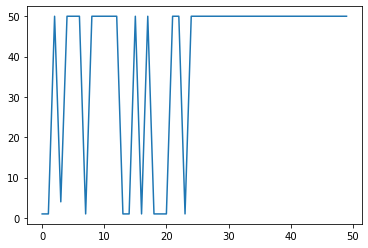

In [77]:
def initqTable(size, actions=[UP, DOWN, LEFT, RIGHT]):
    d = {}
    for i in range(size[0]):
        for j in range(size[1]):
            d[i,j] = np.zeros(len(actions))
    return d

# initGridWorld
gridWorld = GridWorld(gridSize, catP=catP, mouseP=mouseP)
# init q Table
qt = initqTable(gridSize)
# init q Circuit
qNet = QNet(qt, gridWorld, gamma=gamma)
# init cat
cat = Cat(qNet=qNet)
# init pet school
petSchool = PetSchool(cat, EPS, MAX_EPS_STEP)
# start training
petSchool.train()

m emp emp 
emp emp c 
emp emp emp 

qTable:  {(0, 0): array([0., 0., 0., 0.]), (0, 1): array([ 979.  ,  958.42, 1000.  ,    0.  ]), (0, 2): array([0., 0., 0., 0.]), (1, 0): array([1000.        ,    0.        ,  979.        ,  958.41999989]), (1, 1): array([979.    , 938.2516, 979.    , 938.2516]), (1, 2): array([  0.    ,   0.    , 958.42  , 938.2516]), (2, 0): array([0., 0., 0., 0.]), (2, 1): array([958.42  , 938.2516,   0.    ,   0.    ]), (2, 2): array([938.2516  , 918.486568, 938.2516  , 918.486568])}

params:  {(0, 0): (array([0.77132064, 0.02075195, 0.63364823, 0.74880388, 0.49850701,
       0.22479665]), 0.0, 0), (0, 1): (array([1.19814909, 1.88572543, 1.16915678, 0.08833226, 1.68546292,
       1.07834858]), 0.0, 53), (0, 2): (array([0.00394827, 0.51219226, 0.81262096, 0.61252607, 0.72175532,
       0.29187607]), 0.0, 0), (1, 0): (array([2.91777412, 0.71457578, 0.54264437, 0.14207005, 0.37334076,
       0.67403362]), -1.0, 51), (1, 1): (array([9.44190701, 6.43401399, 0.61790114,

C:\Users\sun\AppData\Local\Temp/ipykernel_32288/966535832.py:120: RuntimeWarning: invalid value encountered in double_scalars
  vecx[i,j]=-vecx[i,j]/norm
C:\Users\sun\AppData\Local\Temp/ipykernel_32288/966535832.py:121: RuntimeWarning: invalid value encountered in double_scalars
  vecy[i,j]=-vecy[i,j]/norm


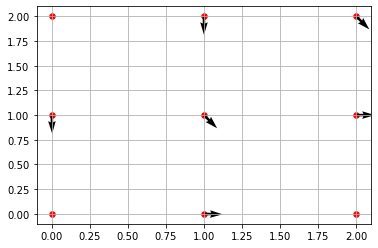

In [78]:
# show what have been learned
petSchool.show()

In [79]:
# @Vasily Bokov
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 1000 # number of measurements 
optimizer = COBYLA(maxiter=500, tol=0.0001) # off the shelf


def qcMaker(params):
    qr = QuantumRegister(2, name="q")
    cr = ClassicalRegister(2, name="c")
    qc = QuantumCircuit(qr, cr)
    qc.u3(params[0], params[1], params[2], qr[0])
    qc.u3(params[3], params[4], params[5], qr[1])
    qc.measure(qr, cr)
    return qc

def calcActions(d):
 
    actions = dict()
    for key in d.keys():
        qc = qcMaker(d[key][0])
        t_qc = transpile(qc, backend)
        job = assemble(t_qc, shots=NUM_SHOTS)
        rlt = backend.run(job).result()
        counts = rlt.get_counts(qc) 
        action = max(counts, key = counts.get)
        actions[key] = action
        
    return actions

# qt is a dict with all q-values
def calcPerformance(d, actions: dict, qt: dict):
    diff = 0
    # the difference between two action is defined as the steps difference between two action
    # e.g. left needs two steps turn to right.
    def difference(a, b):
        if a == UP:
            if b == DOWN:
                return (2*2)/5
            else:
                return 1/5
        elif a == DOWN:
            if b == UP:
                return (2*2)/5
            else:
                return 1/5
        elif a == LEFT:
            if b == RIGHT:
                return (2*2)/5
            else:
                return 1/5
        elif a == RIGHT:
            if b == LEFT:
                return (2*2)/5
            else:
                return 1/5

    for key in d.keys():
        action = ACTIONS[int(actions[key],2)] # "00","01" ..
        targetAction = ACTIONS[np.argmax(qt[key])] # "00","01" ..
        if action != targetAction:
            diff += difference(action, targetAction)
    return diff/len(d.keys())

qt, rets = petSchool.result()
    
print("MSE of trained circuit: ", calcPerformance(rets, calcActions(rets), qt))

MSE of trained circuit:  0.19999999999999998
